# scVelo-RNA velocity analysis of keratinocytes

# Part. Computing RNA velocity using CellRank

## RNA velocity per condition

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import os
import pandas as pd
import anndata as ad
from scipy import io
import loompy
from scipy.sparse import coo_matrix, csr_matrix
import sys

scv.logging.print_version()
sc.logging.print_header()

Running scvelo 0.2.4 (python 3.8.12) on 2022-10-06 15:50.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [2]:
adata=sc.read_h5ad("HumanWounds_scRNA_MainClusters.h5ad")

In [33]:
adata

AnnData object with n_obs × n_vars = 58823 × 25778
    obs: 'barcode', 'SampleID', 'Patient', 'Gender', 'Age', 'Condition', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'doublet_scores', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'ClusterID', 'CellType_fullname', 'CellType', 'BroadCellType'
    var: 'features'
    uns: 'CellType_colors', 'ClusterID_colors', 'log1p'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [34]:
adata.obs

,barcode,SampleID,Patient,Gender,Age,Condition,percent.mt,percent.ribo,percent.hb,percent.malat1,doublet_scores,S.Score,G2M.Score,Phase,CC.Difference,ClusterID,CellType_fullname,CellType,BroadCellType
PWH26D0_AAACCCACACGTAACT-1,PWH26D0_AAACCCACACGTAACT-1,PWH26D0,PWH26,Male,29.0,Skin,5.447562,32.745491,0.0,2.097528,0.015007,-0.024170,0.016767,G2M,-0.040937,6,Spinous-I,Spi-II,Keratinocyte
PWH26D0_AAACCCACACTGAGGA-1,PWH26D0_AAACCCACACTGAGGA-1,PWH26D0,PWH26,Male,29.0,Skin,7.936756,37.161284,0.0,2.460082,0.022768,0.002494,0.025756,G2M,-0.023262,5,Spinous-II,Spi-I,Keratinocyte
PWH26D0_AAACCCAGTCCGACGT-1,PWH26D0_AAACCCAGTCCGACGT-1,PWH26D0,PWH26,Male,29.0,Skin,6.533741,42.505817,0.0,2.386275,0.033618,0.022022,-0.022383,S,0.044405,5,Spinous-II,Spi-I,Keratinocyte
PWH26D0_AAACCCATCAGCGGAA-1,PWH26D0_AAACCCATCAGCGGAA-1,PWH26D0,PWH26,Male,29.0,Skin,5.637100,36.548496,0.0,0.965524,0.016827,-0.027139,-0.047936,G1,0.020797,5,Spinous-II,Spi-I,Keratinocyte
PWH26D0_AAACGAAAGGATAATC-1,PWH26D0_AAACGAAAGGATAATC-1,PWH26D0,PWH26,Male,29.0,Skin,0.507393,33.444477,0.0,5.189910,0.008850,0.020565,-0.041541,S,0.062106,20,Th,Th,Lymphoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWH28D7_TTTGTTGCAACCCTCT-1,PWH28D7_TTTGTTGCAACCCTCT-1,PWH28D7,PWH28,Male,24.0,Wound7,5.609443,39.301157,0.0,3.424097,0.014063,-0.051614,-0.084194,G1,0.032581,20,Th,Th,Lymphoid
PWH28D7_TTTGTTGGTAGCGTAG-1,PWH28D7_TTTGTTGGTAGCGTAG-1,PWH28D7,PWH28,Male,24.0,Wound7,10.283789,9.714313,0.0,3.711086,0.072561,-0.144679,-0.151745,G1,0.007066,8,Granular-II,Gra-I,Keratinocyte
PWH28D7_TTTGTTGGTTGGGAAC-1,PWH28D7_TTTGTTGGTTGGGAAC-1,PWH28D7,PWH28,Male,24.0,Wound7,2.574185,17.040536,0.0,2.427088,0.321937,0.027696,-0.077565,S,0.105261,13,FB-III,FB-III,Fibroblast
PWH28D7_TTTGTTGTCGACATTG-1,PWH28D7_TTTGTTGTCGACATTG-1,PWH28D7,PWH28,Male,24.0,Wound7,3.036437,19.089949,0.0,3.062841,0.015099,-0.101196,-0.095700,G1,-0.005496,18,VE,VE,Endothelial


In [11]:
adata.raw.var.rename(columns = {'_index':'features'}, inplace = True)
adata.raw.var.index = adata.var.index
adata = adata.raw.to_adata()

In [30]:
my_array=adata.raw.X.transpose().toarray()
df=pd.DataFrame(my_array)

In [31]:
display(df.loc[0:49, 0:9])

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# save the raw count data as raw 
adata.raw=adata

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

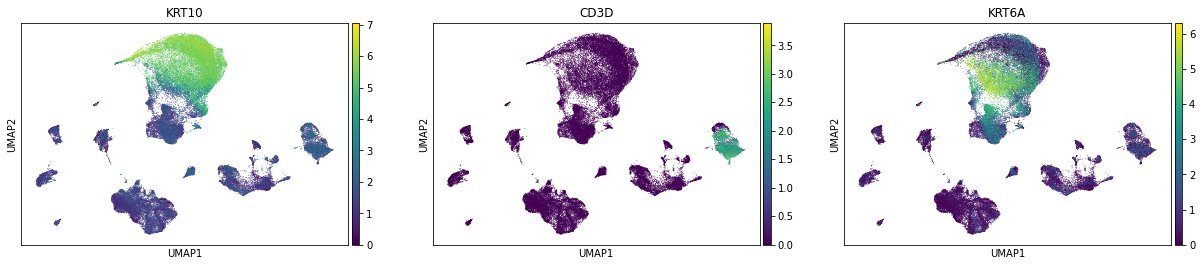

In [27]:
sc.pl.umap(adata, color=['KRT10', "CD3D", "KRT6A"], use_raw = False)

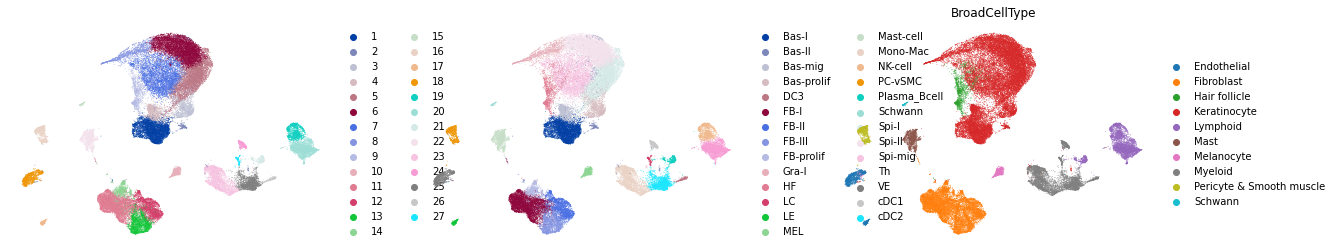

In [35]:
sc.pl.umap(adata, color=['ClusterID', 'CellType', 'BroadCellType'], frameon=False, title=['', ''])

In [36]:
# save dataset as anndata format
adata.write('HumanWounds_scRNA_MainClusters.h5ad', compression='gzip')

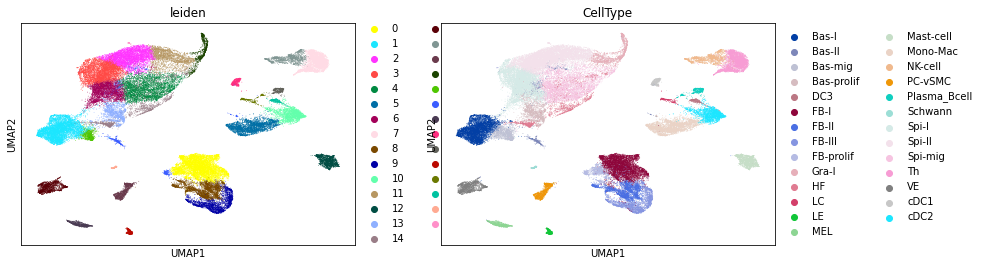

In [39]:
# use the harmony (from seurat) to run the KNN imputation
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, use_rep='X_harmony', knn=True)
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.3, spread=1.5)
sc.pl.umap(adata, color=['leiden',  'CellType'])

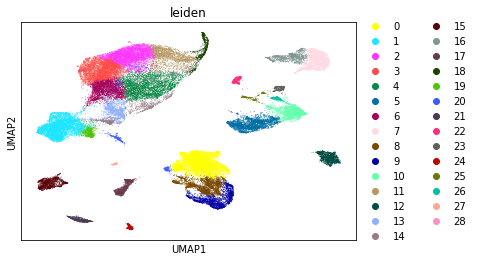

In [40]:
sc.pl.umap(adata, color=['leiden'])

In [57]:
adata=sc.read_h5ad("HumanWounds_scRNA_LymphoidCells.h5ad")

In [58]:
adata

AnnData object with n_obs × n_vars = 5080 × 25778
    obs: 'barcode', 'SampleID', 'Patient', 'Gender', 'Age', 'Condition', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'ClusterID', 'CellType_sameMain', 'CellType'
    var: 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [59]:
adata.obs

,barcode,SampleID,Patient,Gender,Age,Condition,percent.mt,percent.ribo,percent.hb,percent.malat1,S.Score,G2M.Score,Phase,CC.Difference,ClusterID,CellType_sameMain,CellType
PWH26D0_AAACGAAAGGATAATC-1,PWH26D0_AAACGAAAGGATAATC-1,PWH26D0,PWH26,Male,29.0,Skin,0.507393,33.444477,0.0,5.189910,0.000389,-0.098821,S,0.099210,1,Th,ILCs
PWH26D0_AAACGAAGTCACGACC-1,PWH26D0_AAACGAAGTCACGACC-1,PWH26D0,PWH26,Male,29.0,Skin,3.984122,41.664216,0.0,4.307557,-0.022841,-0.007223,G1,-0.015618,0,Th,Th
PWH26D0_AAACGAATCGGAGTAG-1,PWH26D0_AAACGAATCGGAGTAG-1,PWH26D0,PWH26,Male,29.0,Skin,4.436910,35.465802,0.0,4.348467,-0.064071,-0.053342,G1,-0.010729,1,Th,ILCs
PWH26D0_AAAGAACAGTGCTAGG-1,PWH26D0_AAAGAACAGTGCTAGG-1,PWH26D0,PWH26,Male,29.0,Skin,2.272338,45.503854,0.0,2.426492,-0.050542,-0.020533,G1,-0.030009,4,Th,Ttol
PWH26D0_AAAGAACTCTCGCCTA-1,PWH26D0_AAAGAACTCTCGCCTA-1,PWH26D0,PWH26,Male,29.0,Skin,9.661103,26.074861,0.0,8.801214,-0.089765,-0.001051,G1,-0.088714,5,Th,Treg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWH28D7_TTTGACTAGCGAGGAG-1,PWH28D7_TTTGACTAGCGAGGAG-1,PWH28D7,PWH28,Male,24.0,Wound7,6.829429,42.246783,0.0,3.695150,-0.014045,-0.124353,G1,0.110308,2,NK-cell,NK
PWH28D7_TTTGACTTCCGTAGTA-1,PWH28D7_TTTGACTTCCGTAGTA-1,PWH28D7,PWH28,Male,24.0,Wound7,2.548243,25.136071,0.0,9.450767,-0.049950,0.018295,G2M,-0.068246,3,NK-cell,ILC1/NK
PWH28D7_TTTGGAGTCGGAAACG-1,PWH28D7_TTTGGAGTCGGAAACG-1,PWH28D7,PWH28,Male,24.0,Wound7,5.514772,30.116383,0.0,3.813787,-0.034252,-0.005194,G1,-0.029057,3,NK-cell,ILC1/NK
PWH28D7_TTTGGTTGTGAAGCTG-1,PWH28D7_TTTGGTTGTGAAGCTG-1,PWH28D7,PWH28,Male,24.0,Wound7,3.303376,31.527812,0.0,3.643430,-0.066814,-0.072622,G1,0.005808,4,NK-cell,Ttol


In [60]:
adata.raw.var.rename(columns = {'_index':'features'}, inplace = True)
adata.raw.var.index = adata.var.index
adata = adata.raw.to_adata()

In [61]:
my_array=adata.X.transpose().toarray()
df=pd.DataFrame(my_array)

In [62]:
display(df.loc[0:49, 0:9])

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# save the raw count data as raw 
adata.raw=adata

In [64]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

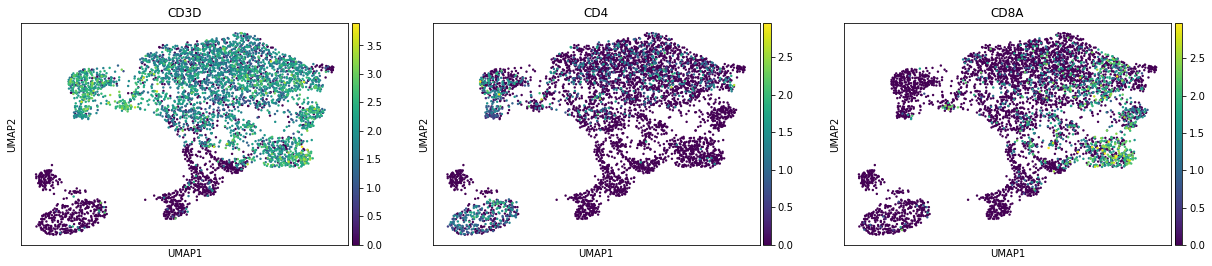

In [66]:
#sc.pl.umap(adata, color=['CD163', "CD68", "IL1B"], use_raw = False)
sc.pl.umap(adata, color=['CD3D', "CD4", "CD8A"], use_raw = False)

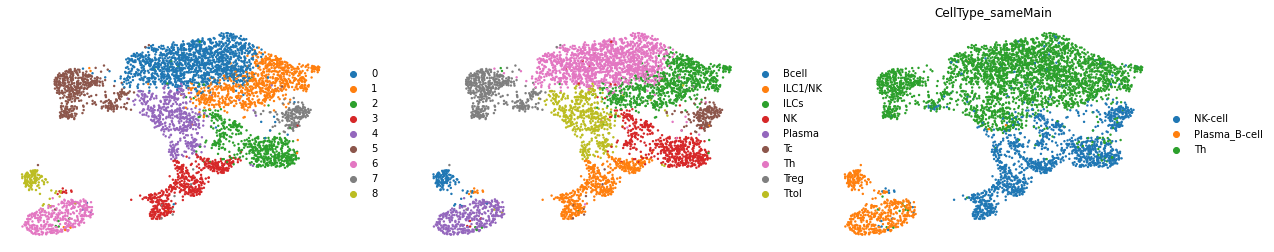

In [67]:
sc.pl.umap(adata, color=['ClusterID', 'CellType', 'CellType_sameMain'], frameon=False, title=['', ''])

In [68]:
# save dataset as anndata format
adata.write('HumanWounds_scRNA_LymphoidCells.h5ad', compression='gzip')